# About the Project and Dataset

Working for a financial institution and part of my job is to build a model that predicts if a credit card transaction is fraudulent or not. I need to model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).

I have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically I have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).

This is a Kaggle dataset. You can find this dataset with the title "Credit Card Fraud Detection"

To train the model, I want to use part of the input dataset, while the remaining data will be utilized to assess the quality of the trained model. First, let's import the necessary libraries and download the dataset.

In [237]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')
# Show all columns
pd.set_option('display.max_columns', None)

In [238]:
path = "C:/Users/micho/OneDrive/Desktop/DATABASE/GITHUB/DATASET/Financial_dataset.csv"

In [239]:
df = pd.read_csv(path)
df[:4]

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0


In [240]:
df.shape

(284807, 32)

Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. My objective is to train a model that uses the other variables to predict the value of the Class variable. I have to first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.

In [241]:
df.columns

Index(['Unnamed: 0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount', 'Class'],
      dtype='object')

In [242]:
df=df.drop('Unnamed: 0', axis=1)
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [243]:
df.duplicated().sum()

np.int64(1081)

In [244]:
df=df.drop_duplicates()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [245]:
df.shape

(283726, 31)

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     283726 

In [247]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


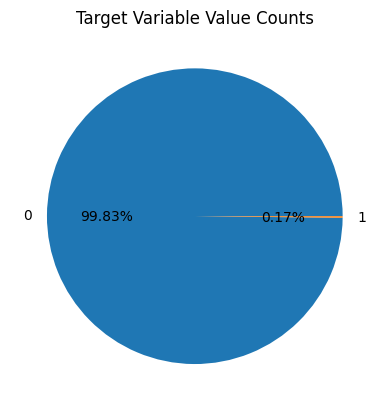

In [248]:
# get the set of distinct classes
labels = df.Class.unique()

# get the count of each class
sizes = df.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

The target variable Class has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). This is a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handling this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

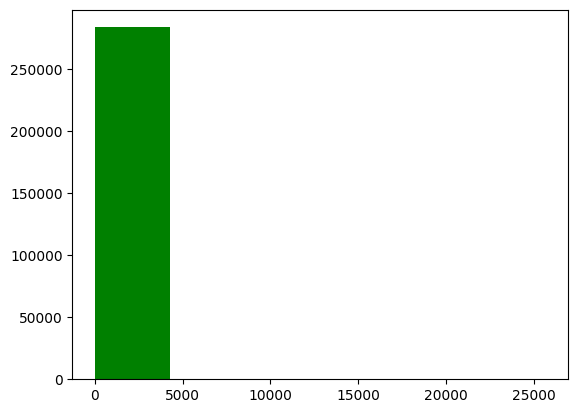

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.38


In [249]:
plt.hist(df.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(df.Amount.values))
print("Maximum amount value is ", np.max(df.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(df.Amount.values, 90))

In [250]:
# data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence
# standardize features by removing the mean and scaling to unit variance
data = df.iloc[:, 1:31]
data = StandardScaler().fit_transform(data)
X, y= df.iloc[:,1:30].values, df.iloc[:,30]
X

array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
         1.33558377e-01, -2.10530535e-02,  1.49620000e+02],
       [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
        -8.98309914e-03,  1.47241692e-02,  2.69000000e+00],
       [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
        -5.53527940e-02, -5.97518406e-02,  3.78660000e+02],
       ...,
       [ 1.91956501e+00, -3.01253846e-01, -3.24963981e+00, ...,
         4.45477214e-03, -2.65608286e-02,  6.78800000e+01],
       [-2.40440050e-01,  5.30482513e-01,  7.02510230e-01, ...,
         1.08820735e-01,  1.04532821e-01,  1.00000000e+01],
       [-5.33412522e-01, -1.89733337e-01,  7.03337367e-01, ...,
        -2.41530880e-03,  1.36489143e-02,  2.17000000e+02]])

In [251]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 283726, dtype: int64

In [252]:
# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (283726, 29) y.shape= (283726,)


In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (198608, 29) Y_train.shape= (198608,)
X_test.shape= (85118, 29) Y_test.shape= (85118,)


### Build a Decision Tree Classifier model with Scikit-Learn

REMEMBER: This is a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handling this case at train time is to bias the model to pay more attention to the samples in the minority class.

In [254]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)


By using these weights, you're telling the model to pay more attention to the minority class(es) during training, which can help improve performance on imbalanced datasets.

### Build a Decision Tree Classifier Machine model with Scikit-Learn

In [255]:

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn DT] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn DT] Training time (s):  8.74657


In [256]:
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]
sklearn_pred

array([0.07334669, 0.07334669, 0.07334669, ..., 0.06482929, 0.07334669,
       0.06334842])

### Build a Support Vector Machine model with Scikit-Learn

In [257]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_svm_time = time.time() - t0
print("[Scikit-Learn SVM] Training time (s):  {0:.2f}".format(sklearn_svm_time))

[Scikit-Learn SVM] Training time (s):  36.88


In [258]:
# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_svm_pred = sklearn_svm.decision_function(X_test)
sklearn_svm_pred

array([-1.56396636, -1.46740544, -2.65422976, ..., -0.89836254,
       -1.08935933, -1.06089205])

## Model Evaluation

Model 1: Decision Tree Model

In [259]:
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))


[Scikit-Learn] ROC-AUC score : 0.873


In [260]:
# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_sklearn))


[Scikit-Learn] Hinge loss:   1.097


Model 2: support Vector Machine

In [261]:
# evaluate accuracy on test set
acc_sklearn_SVM  = roc_auc_score(y_test, sklearn_svm_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn_SVM))

[Scikit-Learn] ROC-AUC score:   0.960


In [262]:
# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

In [263]:
# evaluate the hinge loss from the predictions
loss_svm = hinge_loss(y_test, sklearn_svm_pred)
print("[SVM ML] Hinge loss:   {0:.3f}".format(loss_svm))


[SVM ML] Hinge loss:   0.083


Hinge loss is a loss function that measures the difference between the prediction and the true label in classification tasks.

The model with 0.083 hinge loss is performing significantly better than the one with 1.097.
The difference suggests that the first model (0.083) has found a much better decision boundary that separates the classes more effectively.
The second model (1.097) might benefit from further tuning, feature engineering, or possibly a different kernel if it's an SVM.

In [264]:
training_speedup = sklearn_svm_time/sklearn_time
print('[Support Vector Machine] SVM ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))


[Support Vector Machine] SVM ML vs. Scikit-Learn training speedup : 4.22x 


The Scikit-Learn Decision Tree runs the training routine faster than Support Vetor Machine

#### Author:

[Jolayemi S. Babatunde](linkedin.com/in/babatunde-jolayemi-a05312275)